In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pickle
import datetime
import time
from replay_memory import Storage, deque
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Add, Lambda, Input
from cusotm_atari_preprocessing import AtariPreprocessing
import gym.envs.atari.atari_env

In [9]:
env = gym.envs.atari.atari_env.AtariEnv(game='boxing', obs_type='image', frameskip=1)
env = AtariPreprocessing(env)
optimizer = K.optimizers.Adam(0.00025, beta_1=0.95, beta_2=0.95, epsilon=0.01)

In [3]:
with open('agent_state.state', 'rb') as f:
    params = pickle.load(f)
    exploration_decay = params[0]
    exploration_rate = params[1]
    total_steps = params[2]
    total_eps = params[3]
    total_train_steps = params[4]
    replay_memory = params[5]

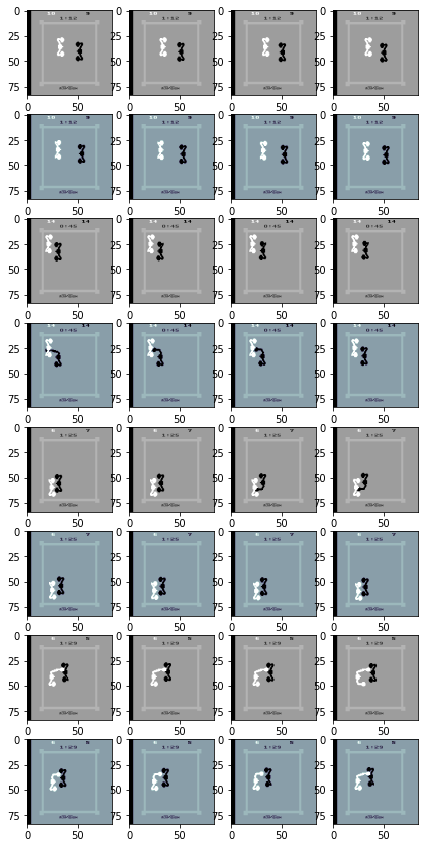

In [4]:
fig = plt.figure(figsize=(7, 15))
rows, cols = 8, 4
axes = []
for i in range(rows*cols):
    axes.append(fig.add_subplot(rows, cols, i+1))

offset = 200
batch = replay_memory.minibatch()

for row in range(rows):
    for col in range(cols):
        idx = row*cols+col
        if row % 2 == 0:
            axes[idx].imshow(batch[0][row][:, :, col], cmap='gray')
        else:
            axes[idx].imshow(batch[3][row-1][:, :, col], cmap='bone')


In [5]:
@tf.function
def my_func(x, y):
  # A simple hand-rolled layer.
  return tf.nn.relu(tf.matmul(x, y))

# Set up logging.
stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = 'logs\\func\\%s' % stamp
writer = tf.summary.create_file_writer(logdir)

# Sample data for your function.
x = tf.random.uniform((3, 3))
y = tf.random.uniform((3, 3))

# Bracket the function call with
# tf.summary.trace_on() and tf.summary.trace_export().
tf.summary.trace_on(graph=True, profiler=False)
# Call only one tf.function when tracing.
z = my_func(x, y)
with writer.as_default():
  tf.summary.trace_export(
      name="my_func_trace",
      step=0)

In [10]:
action_shape = env.action_space.n
state_shape = env.observation_space.shape
def get_model(dueling=False):
    i = Input(state_shape)
    x = Conv2D(32, 8, (4, 4), activation='relu', name='conv1')(i)
    x = Conv2D(64, 4, (2, 2), activation='relu', name='conv2')(x)
    x = Conv2D(64, 3, (1, 1), activation='relu', name='conv3')(x)
    x = Flatten()(x)

    if dueling:
        a = Dense(512, activation='relu')(x)
        a = Dense(action_shape)(a)
        a = Lambda(lambda a: a[:, :] - tf.reduce_mean(a[:, :], axis=-1, keepdims=True),
                   output_shape=(action_shape,))(a)

        v = Dense(512, activation='relu')(x)
        v = Dense(1)(v)
        v = Lambda(lambda s: tf.expand_dims(s[:, 0], -1),
                   output_shape=(action_shape,))(v)

        x = Add()([v, a])
    else:
        x = Dense(512, activation='relu')(x)
        x = Dense(action_shape)(x)

    return K.models.Model(inputs=i, outputs=x)

In [12]:
discount = 0.99
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.dense1 = tf.keras.layers.Dense(100)

    def call(self, inputs):
        outputs = self.dense1(inputs)
        return outputs


step_model = get_model()
target_model = get_model()
optimizer = tf.keras.optimizers.Adam()
writer = tf.summary.create_file_writer(logdir)


@tf.function
def train(data):
    with tf.name_scope("xxx"):
        with tf.GradientTape() as tape:
            y = model(data)
            loss = tf.reduce_mean(tf.square(y))
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

@tf.function
def train_step(batch, scaling=True, double=False):

    tf.print(', executing_eagerly in tain step: {}'.format(tf.executing_eagerly()))
    """
    Train the Step model on a batch of (state, action, reward, next_state, terminal[aka done]) transitions
    :param
    batch: the batch of transition to train on must be in the format:
    [state_array, action_array, reward_array, next_step_array, terminal_array]
    :return:
    None
    """
    s0, a, r, s1, d = batch
    if scaling:  # WE LOVE AUTO GRAPH.... and its support for native python statements
        s0, s1 = s0 / 255, s1 / 255  # scale the pixel values

    r = tf.expand_dims(r, -1)  # has to be expanded for broadcasting (batch_size,) -> (batch_size, 1)
    a = tf.one_hot(a, action_shape, axis=-1)  # one hot encoding (batch_size) -> (batch_size, action_space)

    # creates a mask where 'done' is encoded as 0 and 'not done' is encoded as 1. this can then be multiplied
    # with the 'future reward term in the bellman equation ( y*(Q_target(s', a'=argmax(Q_step(s', a')) )
    # to mask off frames where the concept of a future reward is illogical nonsensical
    done_mask = tf.expand_dims(tf.cast(tf.math.logical_not(d), dtype='float32'), 1)

    if double:
        # Q_step*(s,a)   <--   r + y * (Q_target(s', a'=argmax(Q_step(s', a')) DOUBLE BELLMAN
        pred_s1 = target_model(s1)  # Q_target(s', a') for all a'
        idxs = tf.expand_dims(tf.argmax(step_model(s1), axis=-1), axis=-1)  # a'=argmax(Q_step(s', a')
        s1_qs = tf.expand_dims(tf.gather_nd(pred_s1, idxs, batch_dims=1),
                               -1)  # Q_target(s', a'=argmax(Q_step(s', a')
        act_ys = a * (r + done_mask * (discount * s1_qs))  # r + y*(Q_target(s', a'=argmax(Q_step(s', a'))

    else:
        # Q_step*(s,a)   <--   r + y * max_a'(Q_target(s', a')) BELLMAN
        s1_qs = tf.reduce_max(target_model(s1), keepdims=True, axis=-1)  # max_a'(Q_target(s', a'))
        act_ys = a * (r + done_mask * (discount * s1_qs))  # r + y * max_a'(Q_target(s', a'))

    # gradient descent step, same as supervised learning
    with tf.GradientTape() as tape:
        pre_ys = step_model(s0)
        loss = K.losses.mean_squared_error(act_ys, pre_ys)

    gradients = tape.gradient(loss, step_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, step_model.trainable_variables))


x = np.random.rand(10, 100).astype(np.float32)
# y = model(x)
# train.python_function(x)
tf.summary.trace_on()
train_step(replay_memory.minibatch())
with writer.as_default():
    tf.summary.trace_export("graph", step=0)
    tf.summary.trace_off()
    writer.flush()

, executing_eagerly in tain step: False
